In [1]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
from tensorflow import keras

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Dense
from tensorflow.keras.layers import AveragePooling2D, Flatten, GlobalAveragePooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate

In [5]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.datasets import cifar10
import cv2
from keras.utils import np_utils
import tensorflow.keras.backend as K

In [6]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [7]:
num_classes=10

In [8]:
def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

In [9]:
X_train, y_train, X_test, y_test = load_cifar10_data(56,56)

In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [11]:
#tf.config.experimental.set_visible_devices([], 'GPU')

In [12]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [13]:
input_layer = Input(shape=(56, 56, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,64,96,128,16,32,32,
                     name='inception_3a')

x = inception_module(x,128,128,192,32,96,64,
                     name='inception_3b')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,192,96,208,16,48,64,
                     name='inception_4a')


x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,160,112,224,24,64,64,
                     name='inception_4b')

x = inception_module(x,128,128,256,24,64,64,
                     name='inception_4c')

x = inception_module(x,112,144,288,32,64,64,
                     name='inception_4d')


x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,256,160,320,32,128,128,name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,256,160,320,32,128,128,
                     name='inception_5a')

x = inception_module(x,384,192,384,48,128,128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [15]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 28, 28, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 14, 14, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 14, 14, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [16]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)


In [17]:

lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
             loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [18]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Train on 50000 samples, validate on 10000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/25
50000/50000 [==============================] - 290s 6ms/sample - loss: 3.5384 - output_loss: 2.2136 - auxilliary_output_1_loss: 2.1970 - auxilliary_output_2_loss: 2.2163 - output_accuracy: 0.1582 - auxilliary_output_1_accuracy: 0.1719 - auxilliary_output_2_accuracy: 0.1579 - val_loss: 3.1773 - val_output_loss: 1.9836 - val_auxilliary_output_1_loss: 1.9562 - val_auxilliary_output_2_loss: 2.0016 - val_output_accuracy: 0.2524 - val_auxilliary_output_1_accuracy: 0.2759 - val_auxilliary_output_2_accuracy: 0.2556

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/25
41216/50000 [=======================>......] - ETA: 48s - loss: 3.0453 - output_loss: 1.9067 - auxilliary_output_1_loss: 1.8838 - auxilliary_output_2_loss: 1.9118 - output_accuracy: 0.2765 - auxilliary_output_1_accuracy: 0.2946 - auxilliary_output_2_accuracy: 0.2755

KeyboardInterrupt: 

In [19]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Train on 50000 samples, validate on 10000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/25
50000/50000 [==============================] - 299s 6ms/sample - loss: 3.4947 - output_loss: 2.1866 - auxilliary_output_1_loss: 2.1667 - auxilliary_output_2_loss: 2.1907 - output_acc: 0.1641 - auxilliary_output_1_acc: 0.1825 - auxilliary_output_2_acc: 0.1681 - val_loss: 3.0955 - val_output_loss: 1.9367 - val_auxilliary_output_1_loss: 1.9043 - val_auxilliary_output_2_loss: 1.9464 - val_output_acc: 0.2602 - val_auxilliary_output_1_acc: 0.3004 - val_auxilliary_output_2_acc: 0.2745

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/25
50000/50000 [==============================] - 332s 7ms/sample - loss: 2.9344 - output_loss: 1.8338 - auxilliary_output_1_loss: 1.8215 - auxilliary_output_2_loss: 1.8447 - output_acc: 0.2987 - auxilliary_output_1_acc: 0.3143 - auxilliary_output_2_acc: 0.3006 - val_loss: 2.6379 - val_output_loss: 1.6496 - val

KeyboardInterrupt: 

In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_output_loss', 'val_auxilliary_output_1_loss', 'val_auxilliary_output_2_loss', 'val_output_acc', 'val_auxilliary_output_1_acc', 'val_auxilliary_output_2_acc', 'loss', 'output_loss', 'auxilliary_output_1_loss', 'auxilliary_output_2_loss', 'output_acc', 'auxilliary_output_1_acc', 'auxilliary_output_2_acc', 'lr'])

In [39]:
#tf.debugging.set_log_device_placement(True)

with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)


RuntimeError: /job:localhost/replica:0/task:0/device:GPU:0 unknown device.

In [28]:
tf.test.gpu_device_name()

'/device:GPU:0'

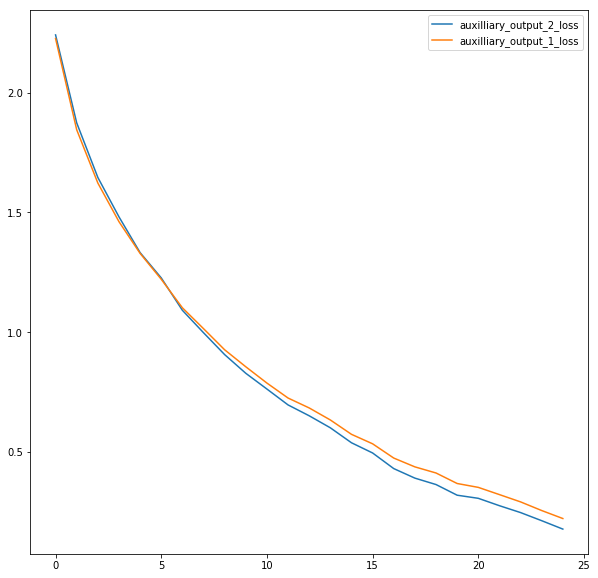

In [49]:
plt.figure(figsize=[10,10])
plt.plot(history.history['auxilliary_output_2_loss'])
plt.plot(history.history['auxilliary_output_1_loss'])
plt.legend(['auxilliary_output_2_loss','auxilliary_output_1_loss'])
plt.show()

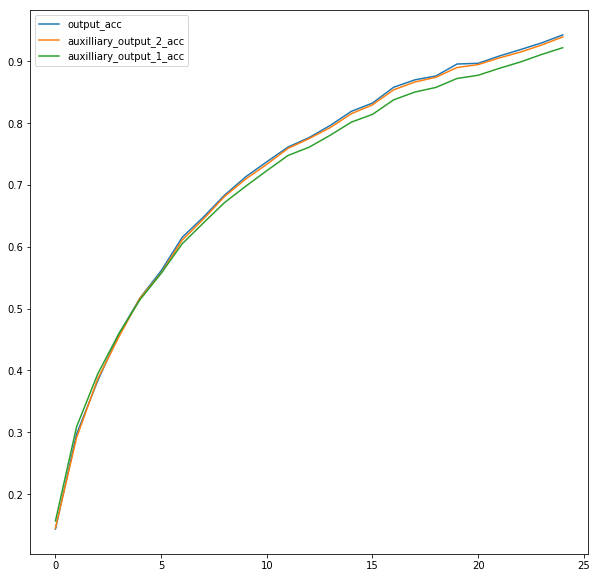

In [48]:
plt.figure(figsize=[10,10])
plt.plot(history.history['output_acc'])
plt.plot(history.history['auxilliary_output_2_acc'])
plt.plot(history.history['auxilliary_output_1_acc'])
plt.legend(['output_acc', 'auxilliary_output_2_acc','auxilliary_output_1_acc'])
plt.show()

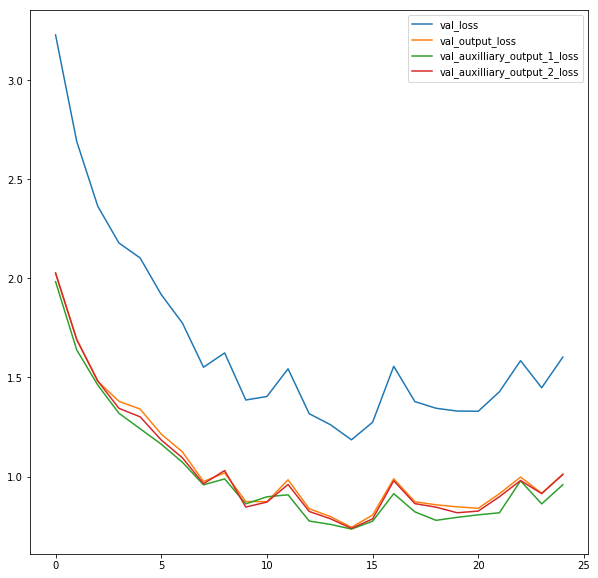

In [50]:
plt.figure(figsize=[10,10])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_output_loss'])
plt.plot(history.history['val_auxilliary_output_1_loss'])
plt.plot(history.history['val_auxilliary_output_2_loss'])
plt.legend(['val_loss', 'val_output_loss', 'val_auxilliary_output_1_loss','val_auxilliary_output_2_loss'])
plt.show()